In [8]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import leastsq
from scipy.stats import norm
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
from scipy.special import factorial

from scipy.stats import poisson
import time
plt.rcParams["figure.figsize"] = (3,3)

T = 1e7
N1 = 11
N2 = 13
N3 = 13
N4 = 11

print (time.ctime())

Tue Apr 14 23:46:15 2020


In [4]:
file1 = "D:/работа/2020/brookhaven sCMOS camera initial data/FastCameraData/FourIons_100s_W0028_H11-200211-012037-1_cent.csv"
data=np.loadtxt(file1, dtype= float, delimiter=",", usecols = (0,1,2))

#print data
y   = data[:, 0]
x  = data[:, 1]
toA = data[:, 2]

tof = []

for i in range(len(x)):
    tof.append(toA[i]/4096.*25.)

for i in range(0,20):
    print (i, x[i],y[i], tof[i])
    
print(len(tof),len(y),len(x))
    

0 84.0 102.0 1354524403.125
1 91.0 98.0 1354605787.5
2 157.0 223.0 1354812981.25
3 200.0 47.0 1354815823.4375
4 16.0 81.0 1354815859.375
5 88.0 100.0 1354857400.0
6 83.0 92.0 1354976450.0
7 80.0 101.0 1355069120.3125
8 94.0 103.0 1355106634.375
9 85.0 104.0 1355123348.4375
10 78.0 100.0 1355334464.0625
11 81.0 98.0 1355444914.0625
12 78.0 94.0 1355444940.625
13 90.0 99.0 1355455989.0625
14 59.0 148.0 1355654123.4375
15 82.0 96.0 1355730917.1875
16 224.0 40.0 1355738976.5625
17 37.0 52.0 1355796343.75
18 83.0 101.0 1355820856.25
19 82.0 88.0 1355884909.375
1396742 1396742 1396742


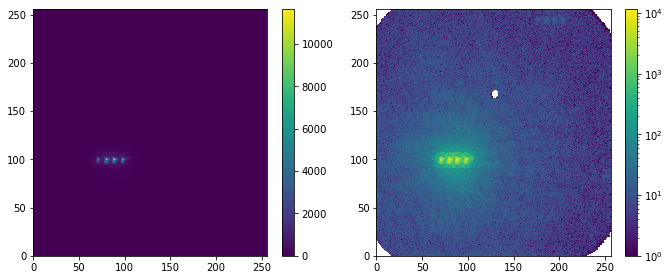

In [5]:
fig, (ax01, ax11) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax01.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)])
fig.colorbar(h[3], ax = ax01)

h = ax11.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax11)
fig.tight_layout()
plt.show()

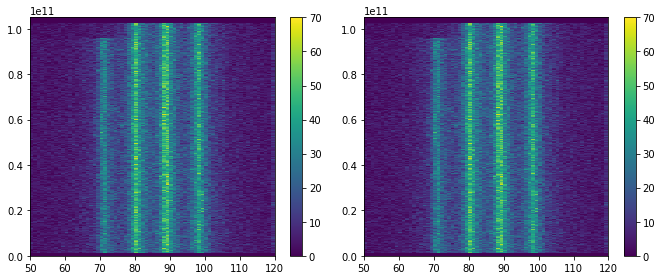

In [6]:
fig, (ax01, ax11) = plt.subplots(ncols=2, figsize=(9.5,4))

#convert to sec, total t = 100sec
tof = []
for i in range(len(x)):
    tof.append(toA[i]/4096.*25.)
    
bins = [70,1000]
range1 = [(50,120),(0,1.05e11)]

h = ax01.hist2d(x, tof, bins, range1)
fig.colorbar(h[3],ax=ax01)

h = ax11.hist2d(x, tof, bins, range1)
fig.colorbar(h[3],ax=ax11)

fig.tight_layout()
plt.show()

In [2]:
class Ion:
    def __init__(self, x0, y0, x1, y1, arrX, arrY, arrT, dT, N, debugPrinting=False):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.dT = dT
        self.N = N
        self.debugPrinting = debugPrinting
        
        assert len(arrX) == len(arrY) and len(arrY) == len(arrT)

        #self.FindBrightRangesPrecise(arrX, arrY, arrT)
        self.FindBrightWindowIntervals(arrX, arrY, arrT)

        #print("bright ranges, %s:" % len(self.brightRanges))
        sum = 0
        for i in self.brightRanges:
            sum += i[1] - i[0]
            if self.debugPrinting:
                print("%s - %s;" % (i[0], i[1]))

        #print("sum time when it was bright: %s sec" % (sum / 1e9))
        
        self.GetEventsInRIO(arrX, arrY, arrT)
        
    # an old function that find precise ranges when the ion was bright, 
    # does not work well with window based analysis.
    def FindBrightRangesPrecise(self, arrX, arrY, arrT):
        prevHits = []
        self.brightRanges = []
        currInterval = None

        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                t = arrT[idx]
                if self.debugPrinting:
                    print("check %s" % t)
                self.DeleteTooOldEvents(t, prevHits, currInterval)
                prevHits.append(t)
                if (len(prevHits) == self.N):
                    currInterval = [prevHits[0], prevHits[-1]]
                    if self.debugPrinting:
                        print("curr interval is started as %s-%s" % (prevHits[0], prevHits[-1]))

        self.DeleteTooOldEvents(1e14, prevHits, currInterval)

    # check if the event coordinates are in the region of interest
    def IsInRegion(self, x0, y0, x1, y1, x, y):
        return x0 <= x and x <= x1 and y0 <= y and y <= y1

    # delete events that are far than dT from the current event, update the bright intervals
    def DeleteTooOldEvents(self, t, prevHits, currInterval):
        while (len(prevHits) > 0 and (t - prevHits[0] > self.dT)):
            if (len(prevHits) == self.N):
                assert (currInterval != None)
                lastRange = None
                if len(self.brightRanges) > 0:
                    lastRange = self.brightRanges[-1]
                if (lastRange != None and lastRange[1] >= currInterval[0]):
                    self.brightRanges.pop()
                    currInterval[0] = lastRange[0]

                currInterval[1] = prevHits[-1]
                self.brightRanges.append(currInterval)
                if self.debugPrinting:
                    print("bright ranges append %s" % currInterval)

            oldElem = prevHits.pop(0)
            if self.debugPrinting:
                print("remove %s, length %s" % (oldElem, len(prevHits)))
                                                             
    def FindBrightWindowIntervals(self, arrX, arrY, arrT):        
        events = []
        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                events.append(arrT[idx])
        
        print(len(events))
        
        self.brightRanges = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            if r - l >= self.N:
                self.brightRanges.append([intervalStart, intervalStart + self.dT])
            l = r
        
        
    def GetIntervalBegin(self, x):
        res = self.dT * (int)(x / self.dT)
        return res

    # Returns if a moment lies in a bright interval.
    def IsBright(self, t):  # O(n), do O(ln(n))
        for i in self.brightRanges:
            if (i[0] <= t and t <= i[1]):
                return True
        return False

    # a helper funtion that returns bright or dark intervals for the ion.
    def GetRanges(self, tStart, tEnd, isBright):
        assert tStart <= self.brightRanges[0][0] <= tEnd

        if isBright:
            return self.brightRanges
        darkRanges = []

        # add the first interval before the first bright
        if tStart != self.brightRanges[0][0]:
            darkRanges.append([tStart, self.brightRanges[0][0]])

        # add all dark intervals between bright intervals
        for ind in range(len(self.brightRanges) - 1):
            prevEnd = self.brightRanges[ind][1]
            nextStart = self.brightRanges[ind + 1][0]
            darkRanges.append([prevEnd, nextStart])

        #add the last interval after the last bright
        if self.brightRanges[-1][1] != tEnd:
            darkRanges.append([self.brightRanges[-1][1], tEnd])

        return darkRanges

    @staticmethod
    def IncreaseIndex(idx):
        if (idx[1] == 0):
            return [idx[0], 1]
        return [idx[0] + 1, 0]

    @staticmethod
    def Intersect(ranges1, ranges2):
        intersections = []
        idx1 = [0,0]
        idx2 = [0,0]

        curInterStart = None

        while idx1[0] < len(ranges1) and idx2[0] < len(ranges2):
            nextX1 = ranges1[idx1[0]][idx1[1]]
            nextX2 = ranges2[idx2[0]][idx2[1]]
            if nextX1 < nextX2 or nextX1 == nextX2 and idx1[1] == 1:
                # is the second currently open?
                if idx2[1] == 1:
                    # the first is opening
                    if idx1[1] == 0:
                        # start a new intersection
                        curInterStart = nextX1

                    # the first is closing
                    else:
                        intersections.append([curInterStart, nextX1])
                        curInterStart = None

                idx1 = Ion.IncreaseIndex(idx1)
            else:
                # if the first currently open?
                if idx1[1] == 1:
                    # the second is opening
                    if idx2[1] == 0:
                        curInterStart = nextX2

                    # the second is closing
                    else:
                        intersections.append([curInterStart, nextX2])
                        curInterStart = None

                idx2 = Ion.IncreaseIndex(idx2)

        return intersections

    @staticmethod
    def IntersectIons(ion1, ion1Bright, ion2, ion2Bright, ion3 = None, ion3Bright = False):
        assert len(ion1.brightRanges) > 0 and len(ion2.brightRanges) > 0
        if ion3 is not None:
            assert len(ion3.brightRange) > 0

        tStart = min(ion1.brightRanges[0][0], ion2.brightRanges[0][0])
        tEnd = max(ion1.brightRanges[-1][1], ion2.brightRanges[-1][1])
        if ion3 is not None:
            tStart = min(tStart, ion3.brightRange[0][0])
            tEnd = max(tEnd, ion3.brightRange[-1][1])

        ranges1 = ion1.GetRanges(tStart, tEnd, ion1Bright)
        ranges2 = ion2.GetRanges(tStart, tEnd, ion2Bright)
        intersections = Ion.Intersect(ranges1, ranges2)

        if ion3 is not None:
            ranges3 = ion3.GetRanges(tStart, tEnd, ion3Bright)
            intersections = Ion.Intersect(intersections, ranges3)

        print("intersections, %s:" % len(intersections))
        sum = 0
        for i in intersections:
            sum += i[1] - i[0]
            # print("%s - %s;" % (i[0], i[1]))
        print("sum time of the intersection %s seconds" % (sum / 1e9))

        return intersections
    
    def GetCountsForEvents(self, events):
        res = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            res.append(r - l)
            l = r
        startTime = events[0]
        endTime = events[-1]
        numberOfWindows = (endTime - startTime) / self.dT
        numberOfWindowsWithEvents = len(res)
        numberOfWindowsWithoutEvents = int(numberOfWindows - numberOfWindowsWithEvents)
        for i in range(numberOfWindowsWithoutEvents):
            res.append(0)
        
        return res
    
    def GetEventsInRIO (self, arrX, arrY, arrT):
        self.xs = []
        self.ys = []
        self.ts = []
        for i in range(len(arrX)-1):
            if (i-(i/10000)*10000 == 1): 
                print (i, time.ctime())
            if ( self.x0 <= arrX[i] <= self.x1 and self.y0 <= arrY[i] <= self.y1): 
                self.xs.append(arrX[i])
                self.ys.append(arrY[i])
                self.ts.append(arrT[i]/4096.*25.)
        print(len(self.xs),len(self.ys),len(self.ts))
        
                
    def PlotCountsInRIO (self):
        self.xs.sort()
        self.xss = []
        self.count = []
        curr = 0
        for idx, val in enumerate(self.xs):
            if (idx != 0 and val == self.xs[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.xss.append(self.xs[idx-2])
                    self.count.append(curr)
                curr = 1
        if (curr != 0):
            self.xss.append(self.xs[-1])
            self.count.append(curr)


        plt.xlim(self.x0,self.x1)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.xss, self.count)
        
    def ReturnHistogramdT(self, bins):
        self.count_h = self.GetCountsForEvents(self.ts)

        print(len(self.count_h))    
        plt.hist(self.count_h, bins = bins) 
        plt.xlabel('counts')
        plt.ylabel('number of events')
        plt.title('exp time of %s nsec' % self.dT)
        plt.show()
        
    def FittingPoisson (self, bins, guess_lambd):
    # the bins should be of integer width, because poisson is an integer distribution!!! that's why it didnt' work before
  
        entries, bin_edges, patches = plt.hist(self.count_h, bins=bins, density=True, label='Data')

        #for idx in range(bins - 1):
            #print(bin_edges[idx])

        
        print(len(bin_edges))
        print(len(entries))

        # calculate bin centres
        #bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        guess_lamb = guess_lambd
        guess  = np.array([guess_lamb])

        def fit_function(k, lamb):
            return poisson.pmf(k, lamb)

        #bin_edges = [1,2,3]
        print("bin edges:")
        print(bin_edges)
        # fit with curve_fit
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries,p0=guess, maxfev = 50000)

        print ('lambda =', popt1[0])

        # plot fit
        data_fit = fit_function(bin_edges[0:-1], *popt1)

        plt.plot(bin_edges[0:-1], data_fit)
        plt.show()

    brightRanges = []

the first ion

28323
28323 28323 28323
2022


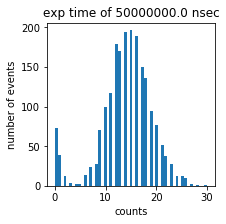

31
30
bin edges:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
lambda = 14.914012448888377


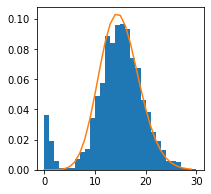

In [7]:
ion1 = Ion(70, 99, 72, 101, x, y, toA,T , N1)
#ion1.PlotCountsInRIO()
ion1.ReturnHistogramdT(53)
ion1.FittingPoisson(30,6)

#x1 = ion1.xs
#y1 = ion1.ys
#t1 = ion.ts

93470
93470 93470 93470
10127


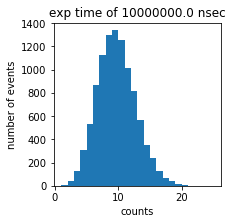

25
24
bin edges:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]
lambda = 9.235329965311532


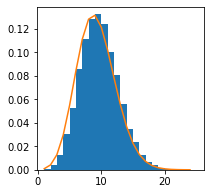

In [9]:
ion2 = Ion(79, 90, 81, 110, x, y, toA, T, N2)
#ion2.PlotCountsInRIO()
ion2.ReturnHistogramdT(24)
ion2.FittingPoisson(24,9)

100370
100370 100370 100370
2026


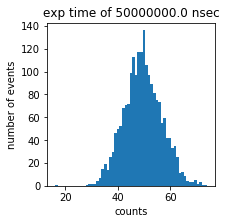

59
58
bin edges:
[16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.
 70. 71. 72. 73. 74.]
lambda = 49.55385826204293


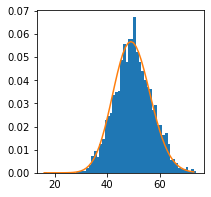

In [19]:
ion3 = Ion(87, 90, 89, 110, x, y, toA, T, N3)
ion3.ReturnHistogramdT(59)
ion3.FittingPoisson(58,50)

83239
83239 83239 83239
10126


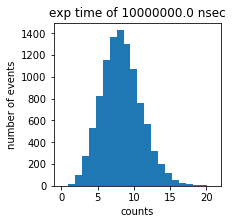

22
21
bin edges:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
lambda = 8.23074763303763


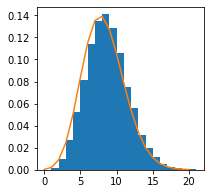

In [11]:
ion4 = Ion(97, 90, 99, 110, x, y, toA, T, N4)
ion4.ReturnHistogramdT(22)
ion4.FittingPoisson(21,9)

background

1831
1831 1831 1831
10118


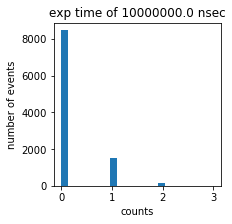

4
3
bin edges:
[0. 1. 2. 3.]
lambda = 0.1778549378024262


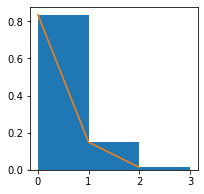

In [13]:
background = Ion(50, 90, 52, 110, x, y, toA, T, N4)
background.ReturnHistogramdT(22)
background.FittingPoisson(3,0.5)